In [ ]:
%pip install googletrans==4.0.0-rc1
%pip install seaborn
%pip install transformers
%pip install tf-keras

In [14]:
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from googletrans import Translator
import seaborn as sns
from datetime import datetime
from time import sleep
from zoneinfo import ZoneInfo
from transformers import pipeline

[nltk_data] Downloading package subjectivity to
[nltk_data]     /Users/carlosamaral/nltk_data...
[nltk_data]   Package subjectivity is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/carlosamaral/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/carlosamaral/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Training classifier


[{'sentence': "I'm so happy today!",
  'negative': 0.0,
  'neutral': 0.412,
  'positive': 0.588,
  'compound': 0.6468,
  'sent_at': '26/09/2024 14:09:48',
  'percent': 58.8},
 {'sentence': 'I feel a deep sadness.',
  'negative': 0.592,
  'neutral': 0.408,
  'positive': 0.0,
  'compound': -0.4404,
  'sent_at': '26/09/2024 14:09:50',
  'percent': 0},
 {'sentence': "I think I'm in love.",
  'negative': 0.0,
  'neutral': 0.417,
  'positive': 0.583,
  'compound': 0.6369,
  'sent_at': '26/09/2024 14:09:52',
  'percent': 58.3},
 {'sentence': "I'm feeling alone.",
  'negative': 0.444,
  'neutral': 0.222,
  'positive': 0.333,
  'compound': -0.128,
  'sent_at': '26/09/2024 14:09:55',
  'percent': 0},
 {'sentence': 'Today was an amazing day!',
  'negative': 0.0,
  'neutral': 0.494,
  'positive': 0.506,
  'compound': 0.6239,
  'sent_at': '26/09/2024 14:09:57',
  'percent': 50.6},
 {'sentence': 'I feel frustrated with work.',
  'negative': 0.531,
  'neutral': 0.469,
  'positive': 0.0,
  'compound':

In [ ]:
# @title Análise

# Baixando os modelos
nltk.download('subjectivity')
nltk.download('vader_lexicon')
nltk.download('punkt')

# Preparando frases para o modelo aprender
datasetRecords = pd.read_csv('dataset.csv', encoding='utf-8', sep=';')
sentences = datasetRecords['frase'].tolist()
paragraph = "It was a beautiful day, and everything seemed to go well at first. I enjoyed my morning coffee, and the weather was perfect for a walk. However, as the day went on, things took a turn for the worse. The meeting at work was stressful, and nothing seemed to go as planned. By the end of the day, I was exhausted and frustrated. But when I got home, my family was there waiting for me with smiles and warm hugs, which made everything feel better."

# Criando conjuntos de frases
n_instances = 100
subj_docs = [(sent, 'subj') for sent in subjectivity.sents(categories='subj')[:n_instances]]
obj_docs = [(sent, 'obj') for sent in subjectivity.sents(categories='obj')[:n_instances]]

# Separando dados para treino e para teste
all_docs = subj_docs + obj_docs
training_docs, testing_docs = train_test_split(all_docs, test_size=0.5, random_state=42)

# Cria o analisador de sentimentos e separa as frases negativas
sentim_analyzer = SentimentAnalyzer()
all_words_neg = sentim_analyzer.all_words([mark_negation(doc) for doc in training_docs])

# Extraí unigramas relevantes para análise de sentimentos
unigram_feats = sentim_analyzer.unigram_word_feats(all_words_neg, min_freq=4)
sentim_analyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigram_feats)

# Treina classificador com dados de treinamento processados
training_set = sentim_analyzer.apply_features(training_docs)
test_set = sentim_analyzer.apply_features(testing_docs)
trainer = NaiveBayesClassifier.train
classifier = sentim_analyzer.train(trainer, training_set)

# Prepara a lista de frases
lines_list = tokenize.sent_tokenize(paragraph)
sentences.extend(lines_list)

# Gera o percentual de felicidade (0 = negativo; 100 = positivo)
def generatePercent(result):
    pos = result['positive']
    neu = result['neutral']
    neg = result['negative']

    total = pos + neu + neg
    if total == 0: return 50  # Se nenhum valor estiver presente, retorno neutro

    # Nova fórmula: foco em (pos - neg) sem o ajuste de 50
    percent = (pos - neg) * 100 / total

    # Garantindo que fique no intervalo de 0 a 100
    if percent < 0: percent = 0
    if percent > 100: percent = 100

    return percent

# Gera o resultado
def doAnalysis(sentence: str) -> object:
  sid = SentimentIntensityAnalyzer()
  ss = sid.polarity_scores(sentence)
  result = {
      'sentence': sentence,
      'negative': ss['neg'],
      'neutral': ss['neu'],
      'positive': ss['pos'],
      'compound': ss['compound'],
      'sent_at': datetime.now(ZoneInfo("America/Sao_Paulo")).strftime("%d/%m/%Y %H:%M:%S")
  }
  result['percent'] = generatePercent(result)
  return result

# Habilitando para o usuário escrever
def realAnalysis(results: list, maxInteractions: int = 3) -> list:
  translator = Translator()
  count = 1
  while count <= maxInteractions:
    userSentence = input('O que você está sentindo?')
    userSentence = translator.translate(userSentence, src='pt', dest='en').text
    result = doAnalysis(userSentence)
    results.append(result)
    count += 1
  return results

def mockAnalysis(results: list, mock: list) -> list:
  translator = Translator()
  for sentence in mock:
    sleep(1)
    sentence = translator.translate(sentence, src='pt', dest='en').text
    result = doAnalysis(sentence)
    results.append(result)
  return results

# Resultados
results = []
sentimentos = [
    "Estou tão feliz hoje!",
    "Sinto uma tristeza profunda.",
    "Acho que estou apaixonado.",
    "Estou me sentindo sozinho.",
    "Hoje foi um dia incrível!",
    "Sinto-me frustrado com o trabalho.",
    "Estou animado para o fim de semana.",
    "Sinto um vazio dentro de mim.",
    "Estou cheio de energia positiva.",
    "Sinto-me ansioso com o que está por vir.",
    "Estou orgulhoso de mim mesmo.",
    "Sinto que não sou ouvido.",
    "Hoje foi um dia cansativo, mas gratificante.",
    "Sinto uma raiva inexplicável.",
]
# realAnalysis(results, 2)
mockAnalysis(results, sentimentos)

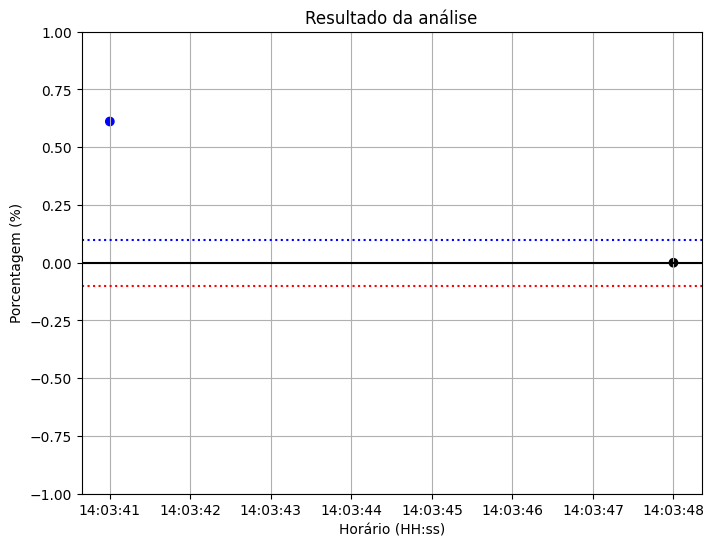

<Figure size 640x480 with 0 Axes>

In [10]:
# @title Gráfico

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.pyplot import figure

def scatterPlot(results: list):
  # Buscando os dados
  data = results
  data = pd.DataFrame(data)
  data = data.sort_values(by=['sent_at'])

  # Filtrando eixos x e y
  sent_at = data['sent_at']
  sent_at = pd.to_datetime(sent_at, dayfirst=True)
  percent = data['compound']

  # Configurando o gráfico
  neutralMargin = 0.10

  colors = []
  for p in percent:
      if (neutralMargin * -1) < p < neutralMargin: # Neutral
          colors.append('black')
      elif p < 0.0: # Negative
          colors.append('red')
      else: # Positive
          colors.append('blue')

  fig, ax = plt.subplots(figsize=(8, 6))
  ax.scatter(sent_at, percent, color=colors)
  ax.set(
      xlabel='Horário (HH:ss)',
      ylabel='Porcentagem (%)',
      title='Resultado da análise'
  )
  ax.grid()
  ax.set_ylim([-1, 1])
  ax.set_yticks(np.arange(-1, 1.25, 0.25))

  ax.axhline(y=neutralMargin * -1, color='red', linestyle=':', label='Margem positiva netro')
  ax.axhline(y=neutralMargin, color='blue', linestyle=':', label='Margem negativa netro')

  ax.axhline(y=0.0, color='black', linestyle='-', label='Referência: 0.0')
  fig.savefig("chat_analysis_scatter_colored.png")

  fig = plt.figure()
  plt.show()

scatterPlot(results)

In [12]:
# @title Título
from transformers import pipeline

# Função para dividir as mensagens em partes menores
def dividir_texto(texto, tamanho_max=1024):
    partes = []
    while len(texto) > tamanho_max:
        # Divide no ponto de palavra mais próximo do limite de tamanho
        corte = texto[:tamanho_max].rfind(' ')
        partes.append(texto[:corte])
        texto = texto[corte:].strip()
    partes.append(texto)
    return partes

# Função para gerar título com base no histórico de mensagens
def gerar_titulo(messages):
    # Junta todas as mensagens em um único texto
    texto = " ".join(messages)

    # Divide o texto se for muito longo
    partes_texto = dividir_texto(texto)

    # Inicializa o modelo de resumo
    summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

    # Gera resumos para cada parte
    resumos = [summarizer(parte, max_length=15, min_length=10, do_sample=True)[0]['summary_text'] for parte in partes_texto]

    # Junta os resumos em um único título
    titulo = " ".join(resumos)

    return titulo

# Exemplo de histórico de mensagens
mensagens = [
    "Estou me sentindo um pouco ansioso hoje.",
    "Você pode me ajudar a entender por que estou sentindo isso?",
    "Claro! Ansiedade pode vir de muitas fontes, como preocupações com o futuro ou estresse acumulado.",
    "Isso faz sentido. Tenho me preocupado com o trabalho ultimamente.",
    "Nos últimos dias, tenho tido dificuldades para dormir, o que está aumentando meu cansaço e minha ansiedade."
]

# Gerar título
titulo = gerar_titulo(mensagens)
print("Título sugerido:", titulo)


/Users/carlosamaral/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RuntimeError: Failed to import transformers.models.bart.modeling_tf_bart because of the following error (look up to see its traceback):
Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

In [ ]:
# @title Detecção de sentimentos faciais

